<a href="https://colab.research.google.com/github/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/blob/main/Ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arviz

     |████████████████████████████████| 1.5MB 11.5MB/s 
     |████████████████████████████████| 737kB 41.2MB/s 
     |████████████████████████████████| 4.7MB 39.7MB/s 
     |████████████████████████████████| 296kB 40.1MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [2]:
!pip install pymc3==3.8

     |████████████████████████████████| 911kB 9.7MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [15]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [197]:
def plot(x, y, mu_pred, y_pred, title, ax):
  idx = np.argsort(x.values)
  x_ord = x.values[idx]
  y_pred_hpd_ord = az.hdi(y_pred, .89)[idx]
  mu_hpd_ord = az.hdi(mu_pred, .89)[idx]
  mu_mean_ord = np.mean(mu_pred, axis=0)[idx]

  ax.scatter(x, y, c='C0', alpha=0.3)
  ax.plot(x_ord, mu_mean_ord, color='C2')
  ax.fill_between(x_ord, mu_hpd_ord[:,0], mu_hpd_ord[:,1], color='C2', alpha=0.25)
  ax.fill_between(x_ord, y_pred_hpd_ord[:,0], y_pred_hpd_ord[:,1], color='C2', alpha=0.25)
  ax.set_xlabel('weight', fontsize=14)
  ax.set_ylabel('height', fontsize=14)
  ax.set_title(title, fontsize=20)

## Linear Regression

In [171]:
url = 'https://raw.githubusercontent.com/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/main/Howell1.csv'
d = pd.read_csv(url, sep=';')
d2 = d[d.age > 18]
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))
d2.head()

,height,weight,age,male,weight_c
0,151.765,47.825606,63.0,1,2.780064
1,139.700,36.485807,63.0,0,-8.559736
2,136.525,31.864838,65.0,0,-13.180705
3,156.845,53.041915,41.0,1,7.996372
4,145.415,41.276872,51.0,0,-3.768671


In [172]:
# 4.42
with pm.Model() as m_4_4_2:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta = pm.Normal('beta', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight_c)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1137.10it/s]


In [173]:
with m_4_4_2:
    summary = pm.summary(
        trace_4_4_2,
        var_names=["alpha", "beta", "sigma"],
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,154.647,0.264,154.142,155.124,0.005,0.004,2725.0,2725.0,2757.0,1703.0,1.0
beta,0.903,0.042,0.828,0.984,0.001,0.001,2884.0,2882.0,2890.0,1376.0,1.0
sigma,5.139,0.196,4.800,5.514,0.004,0.003,2716.0,2705.0,2705.0,1319.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


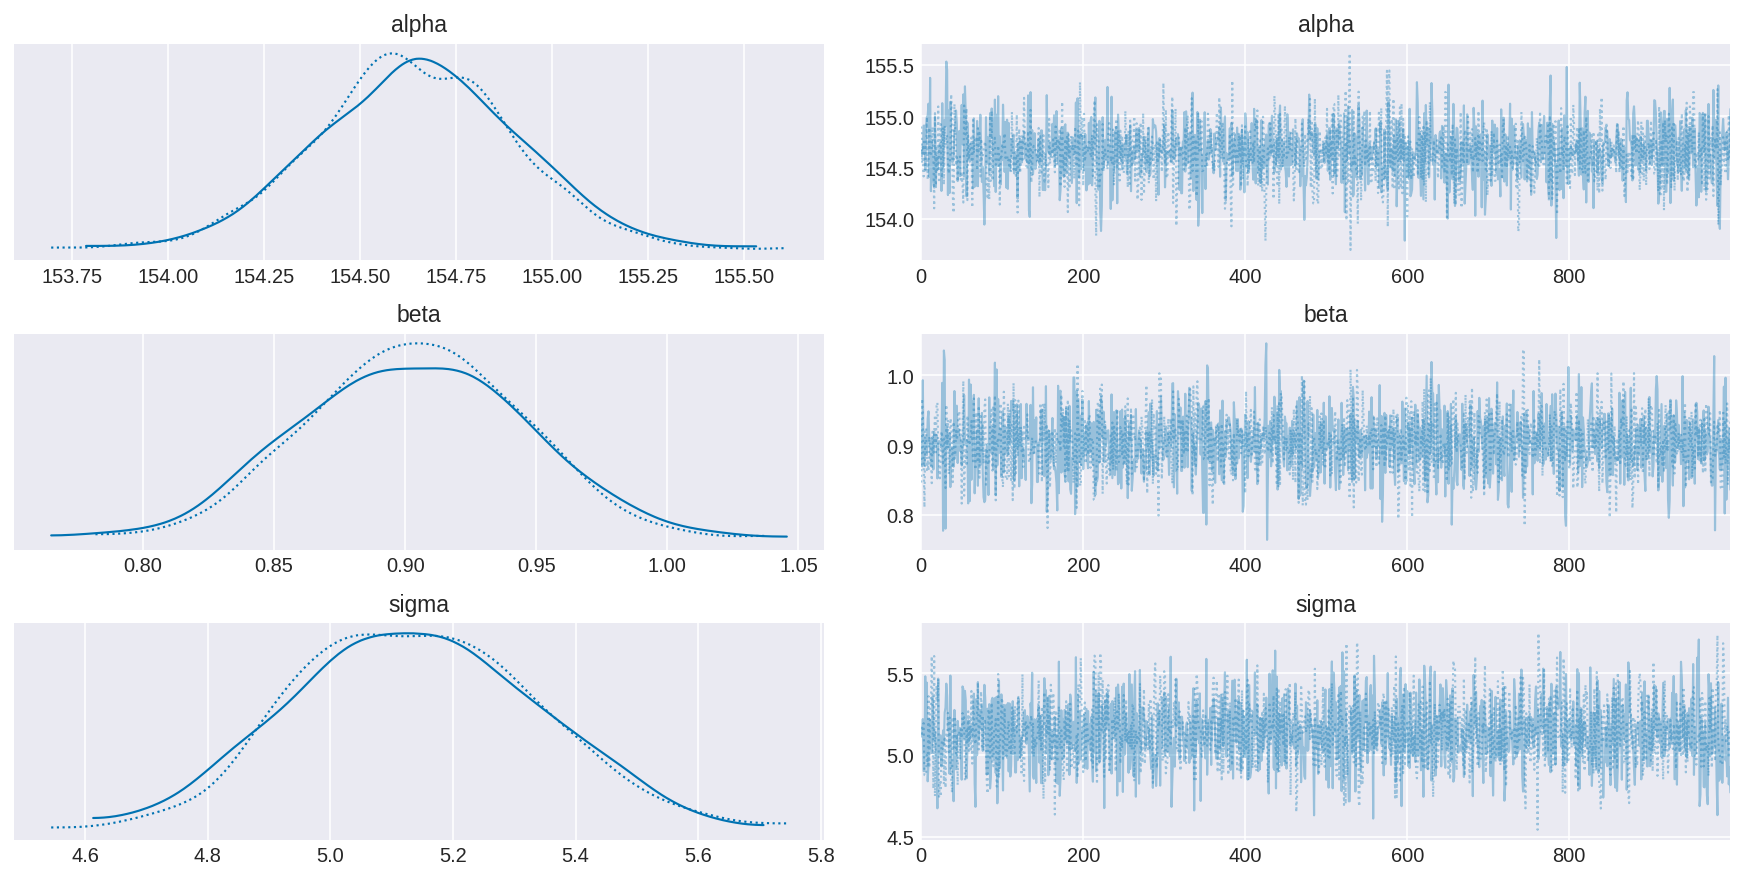

In [174]:
_ = pm.traceplot(trace_4_4_2, var_names=["alpha", "beta", "sigma"])

In [175]:
pm.trace_to_dataframe(trace_4_4_2)[:5]

,alpha,beta,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,mu__10,mu__11,mu__12,mu__13,mu__14,mu__15,mu__16,mu__17,mu__18,mu__19,mu__20,mu__21,mu__22,mu__23,mu__24,mu__25,mu__26,mu__27,mu__28,mu__29,mu__30,mu__31,mu__32,mu__33,mu__34,mu__35,mu__36,...,mu__306,mu__307,mu__308,mu__309,mu__310,mu__311,mu__312,mu__313,mu__314,mu__315,mu__316,mu__317,mu__318,mu__319,mu__320,mu__321,mu__322,mu__323,mu__324,mu__325,mu__326,mu__327,mu__328,mu__329,mu__330,mu__331,mu__332,mu__333,mu__334,mu__335,mu__336,mu__337,mu__338,mu__339,mu__340,mu__341,mu__342,mu__343,mu__344,mu__345
0,154.631437,0.934987,5.113657,157.230760,146.628195,142.307649,162.107940,151.107778,171.411691,148.271592,164.387492,145.117329,163.459767,159.165728,151.054766,146.204092,157.113319,144.163098,157.919927,152.088516,148.377618,158.317523,152.459606,145.700470,147.953515,145.673964,150.206560,164.042908,147.582425,148.510150,156.090984,148.828227,145.779989,156.833164,157.283773,158.715119,158.688613,165.394735,149.093291,159.165728,...,156.727138,155.640375,156.833164,150.710182,159.589831,154.712651,152.008997,151.452362,154.792170,160.438036,158.582587,160.385023,153.519862,145.726977,152.611750,156.250023,151.664413,148.230943,152.999377,162.664575,152.698163,149.702939,153.042747,161.763357,148.457137,152.539125,146.071560,153.864445,148.112554,153.758420,153.678901,157.283773,149.358355,150.895727,150.683676,156.488580,144.534188,161.286241,163.062171,161.630825
1,154.661544,0.869923,5.116232,157.079985,147.215234,143.195348,161.617771,151.383092,170.274090,148.744271,163.738692,145.809507,162.875527,158.880302,151.333768,146.820644,156.970717,144.921680,157.721194,152.295581,148.842918,158.091122,152.640847,146.352069,148.448328,146.327407,150.544588,163.418088,148.103062,148.966228,156.019525,149.262170,146.426054,156.710057,157.129309,158.461050,158.436389,164.675844,149.508789,158.880302,...,156.611410,155.600273,156.710057,151.013163,159.274892,154.737107,152.221595,151.703696,154.811093,160.064072,158.337741,160.014749,153.627322,146.376730,152.782404,156.167496,151.900991,148.706450,153.143057,162.135670,152.862804,150.076012,153.183409,161.297166,148.916904,152.714833,146.697335,153.947927,148.596299,153.849279,153.775294,157.129309,149.755408,151.185797,150.988502,156.389453,145.266946,160.853253,162.505598,161.173857
2,154.636074,0.993043,5.220807,157.396798,146.135885,141.547063,162.576817,150.893621,172.458268,147.881327,164.997913,144.531205,164.012584,159.451914,150.837316,145.685449,157.272065,143.517723,158.128757,151.935255,147.993936,158.551041,152.329387,145.150555,147.543499,145.122403,149.936443,164.631934,147.149367,148.134697,156.186250,148.472525,145.235012,156.974513,157.453102,158.973325,158.945173,166.067700,148.754047,159.451914,...,156.861904,155.707661,156.974513,150.471337,159.902351,154.722331,151.850798,151.259600,154.806788,160.803224,158.832564,160.746919,153.455478,145.178708,152.490979,156.355163,151.484819,147.838154,152.902674,163.168015,152.582758,149.401550,152.948737,162.210838,148.078393,152.413844,145.544687,153.821458,147.712413,153.708849,153.624392,157.453102,149.035570,150.668402,150.443184,156.608534,143.911855,161.704097,163.590299,162.070076
3,154.908465,0.871338,4.902280,157.330841,147.450038,143.423611,161.876010,151.624677,170.546414,148.981563,164.000382,146.042024,163.135812,159.134087,151.575273,147.054806,157.221395,145.152752,157.973093,152.538651,149.080371,158.343623,152.884480,146.585468,148.685139,146.560766,150.784809,163.679256,148.339311,149.203881,156.268654,149.500305,146.659574,156.960311,157.380245,158.714153,158.689451,164.939058,149.747325,159.134087,...,156.861502,155.848720,156.960311,151.254147,159.529319,154.984150,152.464545,151.945803,155.058256,160.319783,158.590643,160.270379,153.872560,146.610170,153.026267,156.416866,152.143419,148.943681,153.387506,162.394752,153.106798,150.315471,153.427924,161.554884,149.154477,152.958586,146.931296,154.193686,148.833351,15

Text(0, 0.5, 'height')

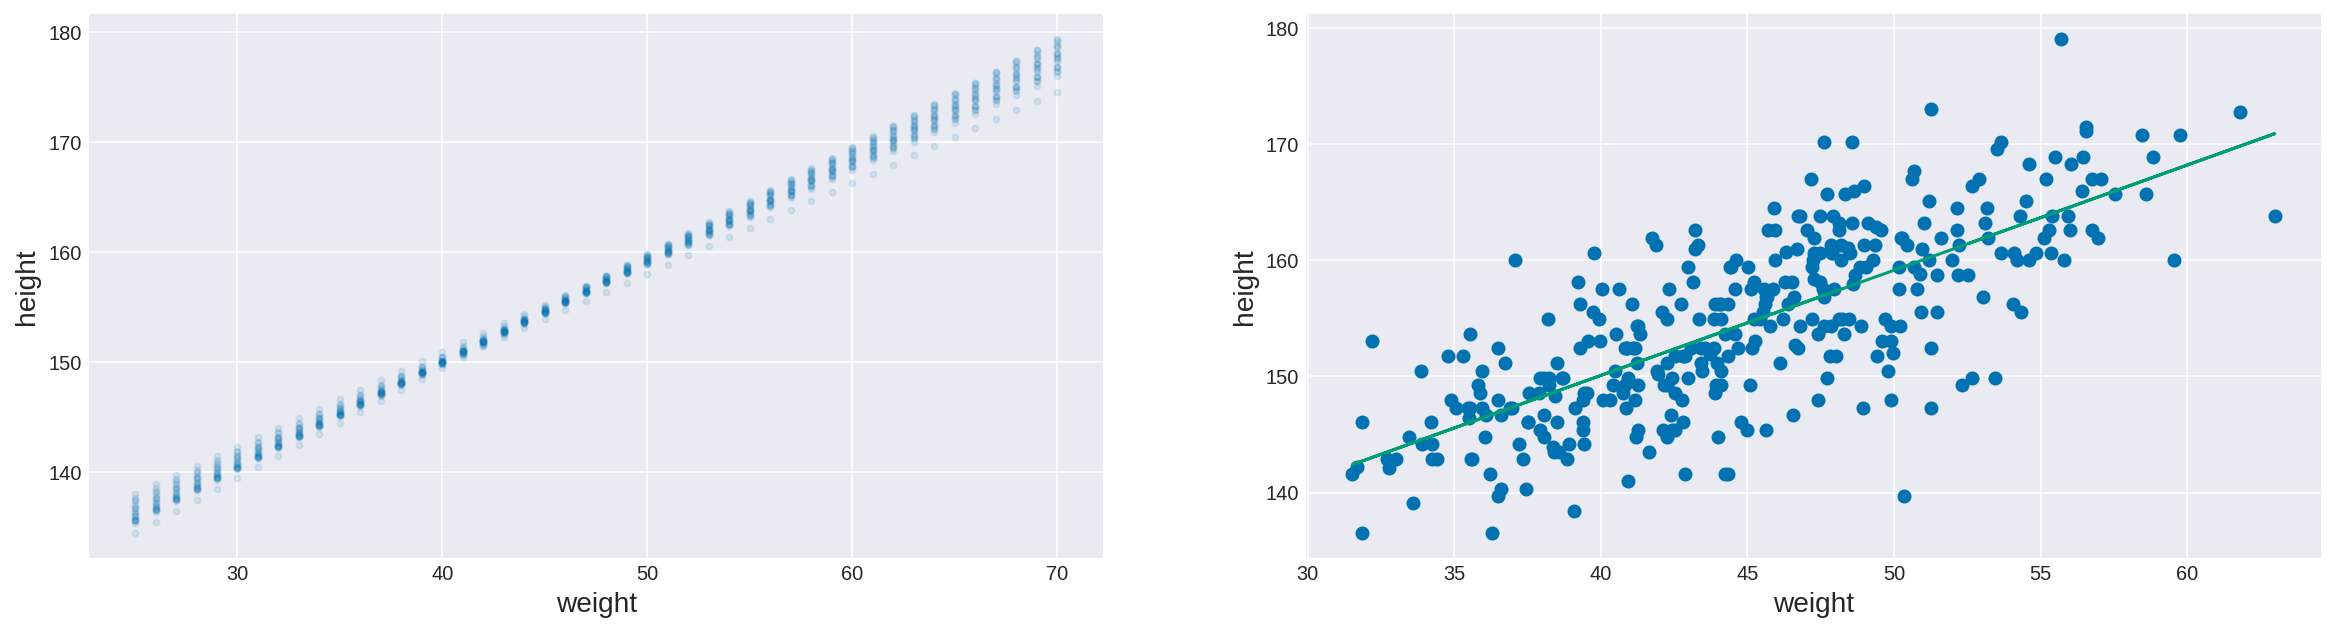

In [106]:
# 4.58
# We are doing manually, what in thebook is done using the link function. 
# In the book on code 4.58 the following operations are performed manually.
weigth_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = trace_4_4_2[::100]
mu_pred = np.zeros((len(weigth_seq), len(chain_N_thinned)*trace_4_4_2.nchains))

for i, w in enumerate(weigth_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * (w - d2.weight.mean())

# plot the sample mu
_, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(weigth_seq, mu_pred, 'C0.', alpha=0.1)
ax[0].set_xlabel('weight', fontsize=14)
ax[0].set_ylabel('height', fontsize=14)

# plot raw data and mean 
ax[1].plot(d2.weight, d2.height, 'o')
ax[1].plot(d2.weight, trace_4_4_2['alpha'].mean() + trace_4_4_2['beta'].mean() * d2.weight_c)
ax[1].set_xlabel('weight', fontsize=14)
ax[1].set_ylabel('height', fontsize=14)

In [176]:
# Now we are going to use sample_ppc() from PyCM3. 
# This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. 
# Thus in the following example the shape of height_pred['height_hat'].shape is (200, 352)
predictive_4_4_2 = pm.sample_ppc(trace_4_4_2, 200, m_4_4_2)
mu_pred_4_4_2 = trace_4_4_2['mu']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 608.67it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


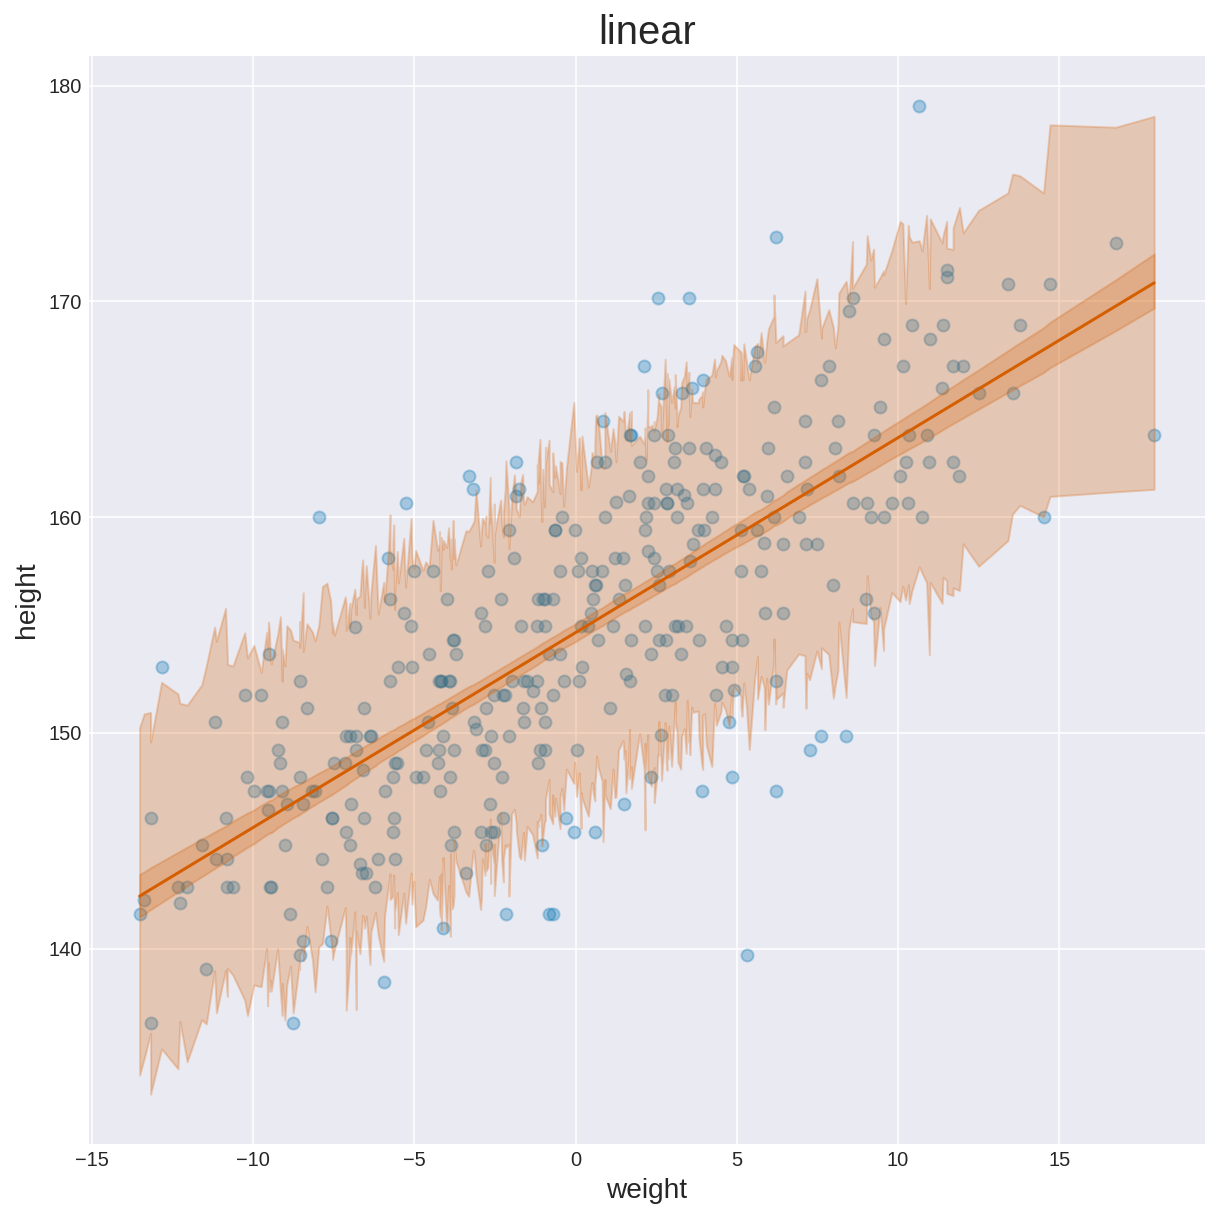

In [198]:
# The solid line is the average line for mean height
# The narrow shadow is the distribution of 89% interval of mu
# The wider shaded region is the 89% interval of the actual height at each weight
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot(d2.weight_c, d2.height, mu_pred_4_4_2, predictive_4_4_2['height'], 'linear', ax)

## Curve From Lines
- Polynominal Regression $\mu_i = \alpha + \beta_1x_i + \beta_2x_i^2$
- B-Splines

In [201]:
url = 'https://raw.githubusercontent.com/yebenbenben/Statistical-Rethinking-with-Python-and-PyMC3/main/Howell1.csv'
d = pd.read_csv(url, sep=';')
d = d.assign(weight_s=pd.Series((d.weight - d.weight.mean())/d.weight.std()))
d.head()

,height,weight,age,male,weight_s
0,151.765,47.825606,63.0,1,0.829869
1,139.700,36.485807,63.0,0,0.059459
2,136.525,31.864838,65.0,0,-0.254483
3,156.845,53.041915,41.0,1,1.184257
4,145.415,41.276872,51.0,0,0.384957


In [215]:
with pm.Model() as model_linear:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta1 = pm.Lognormal('beta1', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta1 * d.weight_s)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_linear = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta1, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1017.31it/s]


In [202]:
with pm.Model() as quadratic:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta1 = pm.Lognormal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta1 * d.weight_s + beta2 * d.weight_s**2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_quadratic = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta2, beta1, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 536.78it/s]


In [214]:
with pm.Model() as model_cubic:
    alpha = pm.Normal('alpha', mu=178, sd=20)
    beta1 = pm.Lognormal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    beta3 = pm.Normal('beta3', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta1 * d.weight_s + beta2 * d.weight_s**2 + beta3 * d.weight_s**3)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_cubic = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta3, beta2, beta1, alpha]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:05<00:00, 382.77it/s]


In [217]:
# calculate the mu hpd
mu_pred_linear = trace_linear['mu']
mu_pred_quadratic = trace_quadratic['mu']
mu_pred_cubic = trace_cubic['mu']

# generate sample predictive for height and caculate hpd
predictive_linear = pm.sample_ppc(trace_linear, 200, model_linear)
predictive_quadratic = pm.sample_ppc(trace_quadratic, 200, model_quadratic)
predictive_cubic = pm.sample_ppc(trace_cubic, 200, model_cubic)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  import sys
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 740.12it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 200/200 [00:00<00:00, 675.29it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  if __name__ == '__main__':
100%|██████████| 200/200 [00:00<00:00, 689.31it/s]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


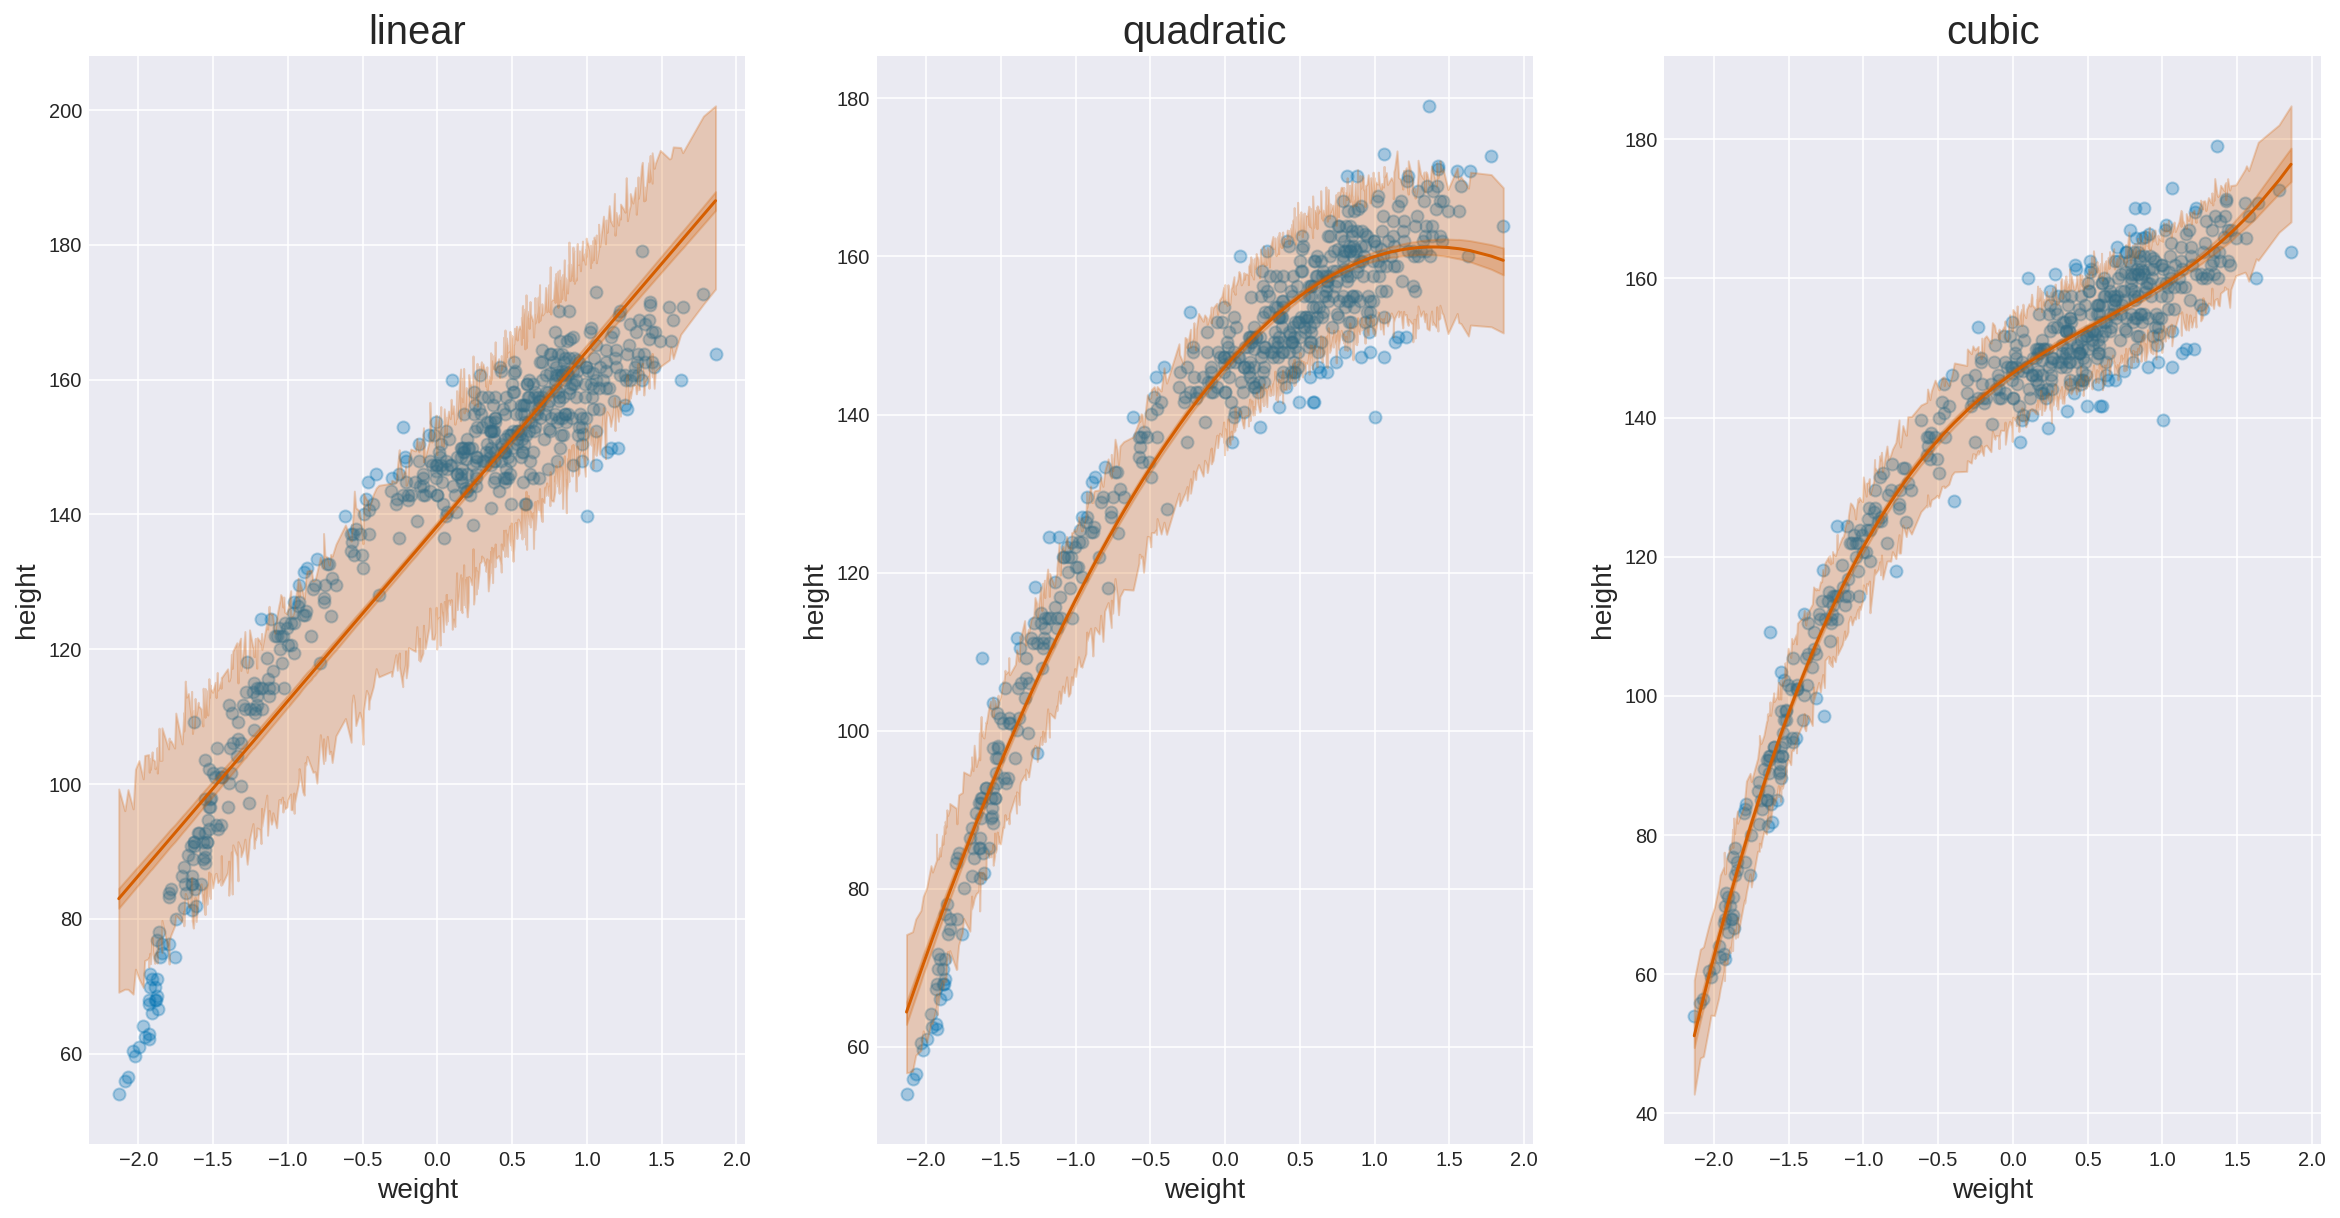

In [219]:
_, ax = plt.subplots(1, 3, figsize=(20, 10))
plot(d.weight_s, d.height, mu_pred_linear, predictive_linear['height'], 'linear', ax[0])
plot(d.weight_s, d.height, mu_pred_quadratic, predictive_quadratic['height'], 'quadratic', ax[1])
plot(d.weight_s, d.height, mu_pred_cubic, predictive_cubic['height'], 'cubic', ax[2])